# Adult income dataset
*Source: https://www.kaggle.com/datasets/wenruliu/adult-income-dataset*

In [1]:
import warnings
warnings.filterwarnings("ignore")

import merci
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score

pd.set_option('display.max_columns', None)
SEED = 123

### About the dataset
#### Attribute Information:

- **age:** continuous.
- **workclass:** Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- **fnlwgt:** continuous.
- **education:** Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- **education-num:** continuous.
- **marital-status:** Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- **occupation:** Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- **relationship:** Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- **race:** White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- **sex:** Female, Male.
- **capital-gain:** continuous.
- **capital-loss:** continuous.
- **hours-per-week:** continuous.
- **native-country:** United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
- **class:** >50K, <=50K 



#### Class Distribution:
**Probability for the label '>50K' :** 23.93% / 24.78% (without unknowns)

**Probability for the label '<=50K' :** 76.07% / 75.22% (without unknowns) 


In [2]:
income_df = pd.read_csv('data/adult.csv')
income_df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
# No missing values
income_df.isna().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

We consider the education attribute as ordinal, therefore only `aducational-num` is used and `education` is dropped. Also, >90% of the data has `native-country` == US.

In [4]:
income_df.drop(columns=['education', 'native-country'], inplace=True)

In [5]:
def plot_class_frequencies(df: pd.DataFrame, 
                           attributes: list, 
                           rows: int = None, 
                           cols: int = None) -> None:
    if rows is None and cols is None:
        rows = 2
        cols = len(attributes) // 2+1
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    num_cols = ['educational-num', 'age']

    for i, attr in enumerate(attributes):
        
        sort_col = attr if attr in num_cols else 'fnlwgt'
        asc = True if attr in num_cols else False

        row = i // cols
        col = i % cols

        classes_df = (
            df[[attr, 'fnlwgt']]
            .groupby(attr)
            .count()
            .reset_index()
            .sort_values(by=sort_col, ascending=asc)
        )

        ax = axes[row, col] if rows > 1 else axes[col]
        bars = ax.bar(classes_df[attr], classes_df['fnlwgt'], color="green")
        ax.set_title(attr.upper())
        ax.set_ylabel("count")
        ax.set_xticklabels(classes_df[attr], rotation=45, ha='right')

        # for bar in bars:
        #     yval = bar.get_height()
        #     ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va="bottom", ha='center')

    plt.tight_layout()
    plt.show()

In [6]:
income_df.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


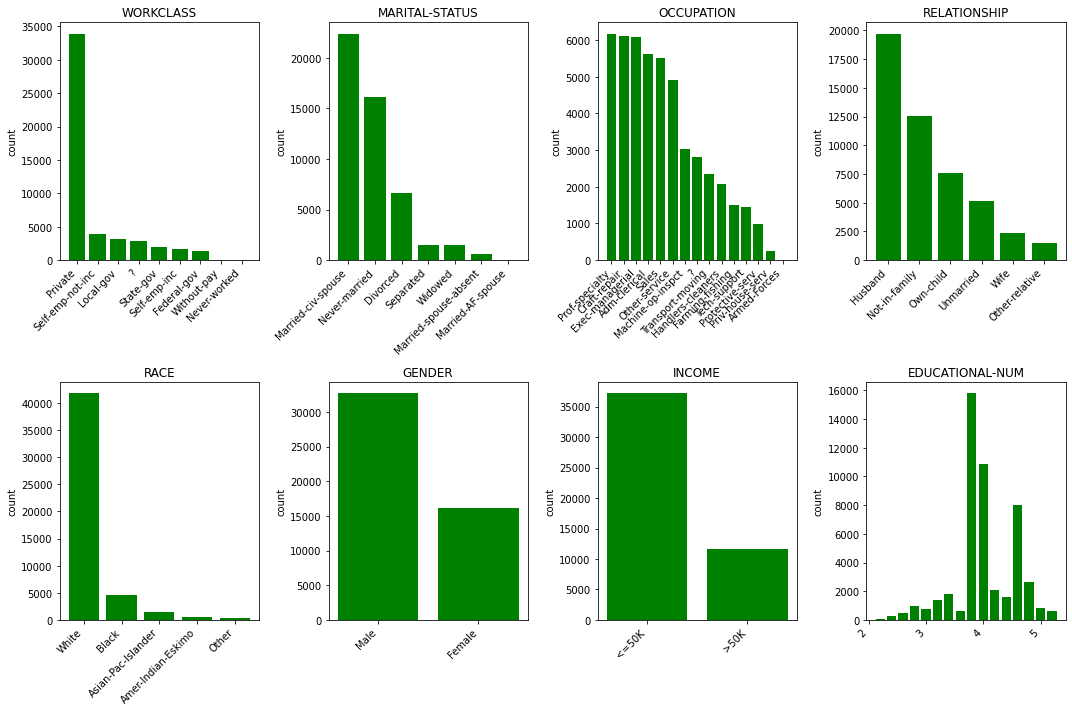

In [7]:
categorical_cols = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'income']

plot_class_frequencies(income_df, categorical_cols+['educational-num'], rows=2, cols=4)

### Utilize the FairnessEvaluator to identify which groups may be susceptible to being predicted with the low income class

In [8]:
class RandomModel:
    def __init__(self, seed: int = 1) -> None:
        np.random.seed(seed)
        self.num_classes = 0
        
    def fit(self, X, y):
        self.num_classes = len(np.unique(y))

    def predict_proba(self, X):
        result = np.random.uniform(0, 1, size=(X.shape[0], self.num_classes))
        return result / result.sum(axis=1).reshape(-1, 1)

    def predict(self, X):
        return np.random.randint(0, self.num_classes, X.shape[0])

In [9]:
ohe_df = pd.get_dummies(
        income_df,
        columns=categorical_cols,
        dtype=float,
        drop_first=True,
    )

ohe_columns = [*ohe_df.columns.str.lower()]
ohe_df.columns = ohe_columns
display(ohe_df.head())
len(ohe_df.columns)

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass_federal-gov,workclass_local-gov,workclass_never-worked,workclass_private,workclass_self-emp-inc,workclass_self-emp-not-inc,workclass_state-gov,workclass_without-pay,marital-status_married-af-spouse,marital-status_married-civ-spouse,marital-status_married-spouse-absent,marital-status_never-married,marital-status_separated,marital-status_widowed,occupation_adm-clerical,occupation_armed-forces,occupation_craft-repair,occupation_exec-managerial,occupation_farming-fishing,occupation_handlers-cleaners,occupation_machine-op-inspct,occupation_other-service,occupation_priv-house-serv,occupation_prof-specialty,occupation_protective-serv,occupation_sales,occupation_tech-support,occupation_transport-moving,relationship_not-in-family,relationship_other-relative,relationship_own-child,relationship_unmarried,relationship_wife,race_asian-pac-islander,race_black,race_other,race_white,gender_male,income_>50k
0,25,226802,7,0,0,40,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,38,89814,9,0,0,50,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,28,336951,12,0,0,40,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
3,44,160323,10,7688,0,40,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
4,18,103497,10,0,0,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


45

In [10]:
X, y = ohe_df.drop(columns='income_>50k').to_numpy().astype(float), ohe_df['income_>50k'].to_numpy().astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

#### Fairness measures - remainder:
- **predictive parity:** P(Y = 1|d = 1, G = m) = P(Y = 1|d = 1, G = f)
- **predictive equality:** P(d = 1|Y = 0, G = m) = P(d = 1|Y = 0, G = f)
- **equal opportunity:** P(d = 0|Y = 1, G = m) = P(d = 0|Y = 1, G = f)
- **equalized odds:** P(d = 1|Y = i, G = m) = P(d = 1|Y = i, G = f ), i ∈ 0, 1
- **conditional use accuracy:** (P(Y = 1|d = 1, G = m) = P(Y = 1|d = 1, G = f )) ∧ (P(Y = 0|d = 0, G = m) = P(Y = 0|d = 0, G = f))
- **overall accuracy equality:** P(d = Y , G = m) = P(d = Y , G = f )
- **treatment equality:** FN/FP (G = m) = FN/FP (G = f)

In [11]:
# select sensitive attribute
sensitive_columns = ['gender_male', 'race_black']

# select the fairness measure
measures = ['predictive_parity']

# models
models = {
    "RandomModel": RandomModel,
    "AdaBoost": AdaBoostClassifier,
    "NearestNeighbors": KNeighborsClassifier,
    "DecisionTree": DecisionTreeClassifier,
    "LogisticRegression": LogisticRegression,
}

In [12]:
def compare_models_fairness(models: dict[str, merci.types.Classifier],
                            train_dataset: tuple[np.ndarray], 
                            test_dataset: tuple[np.ndarray], 
                            sensitive_columns: str, 
                            measures: list[str], 
                            verbose=False) -> pd.DataFrame:
    if verbose:
        print(f"sensitive attributes: {sensitive_columns}")
    results = {'model':[], 'f1_score':[], 'accuracy':[]}
    for s_col in sensitive_columns:
        for measure in measures:
            results[f"{measure}_{s_col}"] = []

    for model_name, model_class in models.items():

        results['model'].append(model_name)
        model = model_class()
        model.fit(*train_dataset)

        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        results['f1_score'].append(f1)
        accuracy = accuracy_score(y_test, y_pred)
        results['accuracy'].append(accuracy)

        for s_col in sensitive_columns:

            evaluator = merci.evaluate.FairnessEvaluator(
                model, train_dataset, test_dataset, sensitive_attribute_idx=ohe_columns.index(s_col)
            )

            for measure in measures:
                result = evaluator.evaluate(measure=measure)
                results[f"{measure}_{s_col}"].append(result)

                if verbose:
                    print(f"\n{model_name.upper()}:")
                    print(f"f1 score: {f1:.5f}")
                    print(f"accuracy: {accuracy:.5f}")
                    print(f"{measure}: {result:.5f}")

    return pd.DataFrame(results)

In [14]:
res_df = compare_models_fairness(models, (X_train, y_train), (X_test, y_test), sensitive_columns, measures)
res_df

,model,f1_score,accuracy,predictive_parity_gender_male,predictive_parity_race_black
0,RandomModel,0.328904,0.503736,0.199113,0.125056
1,AdaBoost,0.674131,0.859965,0.039632,0.060551
2,NearestNeighbors,0.418343,0.777971,0.264566,0.224009
3,DecisionTree,0.617678,0.813594,0.160401,0.120528
4,LogisticRegression,0.395624,0.796397,0.268281,0.185436


For `predictive_parity` measure `AdaBoost` model appears to be the best in terms of the accuracy-fairness trade-off.